In [6]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor, sin, cos, sqrt, atan2, radians, asin
import glob
import os
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
import folium
import geopandas as gpd
from itertools import combinations
#import networkx as nx

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

base = 'Data'
police_complaints_dataset="police_complaints"
#base = '/home/bsilva/Desktop'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3/'

In [7]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base, year_start, year_end):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(year_start) + ".csv", sep=";")
    
    for year in range(year_start+1, year_end+1):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base+"/noise_data/csv_format", 2016, 2019)


#secalhar eliminar...
def saving_dfs_as_binary_files(base, file_list, raw_name):
    
    df = pd.read_csv(base+'/'+file_list[0]+ ".csv", sep=";")
    
    for file in file_list[1:]:
        _df_file = pd.read_csv(base+'/'+file+ ".csv", sep=";")
        df = pd.concat([df, _df_file])
    
    pickle.dump(df, open(base+'/'+raw_name, "wb"))
        


In [10]:

# Opening data
def get_sensors_data():
    df = pickle.load(open(base+'/'+"noise_data/csv_format/df_raw", "rb" ))

    for col in ['C1', 'C2', 'C3', 'C4', 'C5']:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"], format='%d-%m-%Y')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)


    return df[['date', 'year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5']]
    
df = get_sensors_data()
df

,date,year,month,day,hour,C1,C2,C3,C4,C5
0,2016-06-01,2016,6,1,0,61.1,58.8,63.7,60.4,60.2
1,2016-06-01,2016,6,1,1,57.2,56.1,60.4,57.7,58.4
2,2016-06-01,2016,6,1,2,52.5,53.4,52.9,56.7,56.5
3,2016-06-01,2016,6,1,3,50.6,46.6,45.7,47.9,55.6
4,2016-06-01,2016,6,1,4,47.4,46.2,45.1,45.8,56.8
...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31,2019,12,31,19,62.2,59.8,60.3,NaN,NaN
8756,2019-12-31,2019,12,31,20,59.4,59.7,55.9,NaN,NaN
8757,2019-12-31,2019,12,31,21,59.2,61.0,56.0,NaN,NaN
8758,2019-12-31,2019,12,31,22,57.0,60.2,56.0,NaN,NaN


In [61]:
def append_to_df(df, path, xlsx=False, sep=','):
    df=pd.concat([
        df, 
        pd.read_excel(path, engine='openpyxl') if xlsx else pd.read_csv(path, sep=sep, encoding='latin-1')
    ])
    
    return df
 
def read_complaints():
    df_complaints=pd.read_csv('./Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', sep=',')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/Contact_Gennaio_Giugno_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx', xlsx=True)
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep=';')
 
    return df_complaints
 
df_complaints=read_complaints()
df_complaints

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,6.0,AEROPORTO/(STRADA DELL') ...,NaN,02/01/2016,NaN
1,Allarme Sociale,Altro,8.0,MADAMA CRISTINA/(PIAZZA) ...,NaN,13/01/2016,NaN
2,Allarme Sociale,Altro,2.0,RENI/GUIDO (VIA) ...,NaN,15/01/2016,NaN
3,Allarme Sociale,Altro,2.0,TRIPOLI/(VIA) ...,NaN,27/01/2016,NaN
4,Allarme Sociale,Altro,7.0,S. GIULIA/(PIAZZA) ...,NaN,03/02/2016,18.45
...,...,...,...,...,...,...,...
830,Qualità Urbana,Decoro e degrado urbano,4.0,AQUILA/(VIA) ...,NaN,26/12/2019,9.34
831,Qualità Urbana,Decoro e degrado urbano,5.0,VILLARI/PASQUALE (PIAZZA) ...,NaN,29/12/2019,9.08
832,Qualità Urbana,Decoro e degrado urbano,9.0,GALIMBERTI/TANCREDI (PIAZZA) ...,NaN,30/12/2019,12.57
833,Qualità Urbana,Decoro e degrado urbano,5.0,VERONESE/PAOLO (VIA) ...,NaN,31/12/2019,9.40


In [63]:
df_complaints['Sottocategoria Criminologica'].unique()

array(['Altro', 'Atti di vandalismo', 'Aggregazioni giovanili',
       'Comportamenti molesti', 'Disturbi altri animali', 'Disturbi Cani',
       'Disturbi da locali', 'Rumori molesti',
       'Uso improprio parti comuni', 'Decoro e degrado urbano',
       'Veicoli abbandonati'], dtype=object)

Not all of the complaints are relevant to this challenge, such as complaints regarding abandoned vehicles, vandalism or aggressions. Therefore we are only interested in complaints regarding loud noises (Rumori molesti).

In [64]:
df_complaints = df_complaints.loc[df_complaints['Sottocategoria Criminologica'] == 'Rumori molesti']
df_complaints

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
537,Convivenza Civile,Rumori molesti,3.0,MARTINI MAURI/ENRICO (VIA) ...,NaN,04/01/2016,NaN
538,Convivenza Civile,Rumori molesti,5.0,MORTARA/(CORSO) ...,NaN,04/01/2016,NaN
539,Convivenza Civile,Rumori molesti,7.0,COLLETTA/PIETRO (LUNGO DORA) ...,NaN,10/01/2016,NaN
540,Convivenza Civile,Rumori molesti,9.0,NIZZA/(VIA) ...,NaN,15/01/2016,NaN
541,Convivenza Civile,Rumori molesti,7.0,CIGNA/FRANCESCO (LARGO) ...,NaN,16/01/2016,NaN
...,...,...,...,...,...,...,...
437,Convivenza Civile,Rumori molesti,7.0,REGGIO/(VIA) ...,NaN,28/11/2019,NaN
438,Convivenza Civile,Rumori molesti,1.0,BERTOLA/ANTONIO GIUSEPPE (VIA) ...,NaN,28/11/2019,11.49
439,Convivenza Civile,Rumori molesti,3.0,SESTRIERE/(VIA) ...,NaN,06/12/2019,NaN
440,Convivenza Civile,Rumori molesti,4.0,GAMBA/ENRICO (CORSO) ...,NaN,13/12/2019,8.37


<AxesSubplot:>

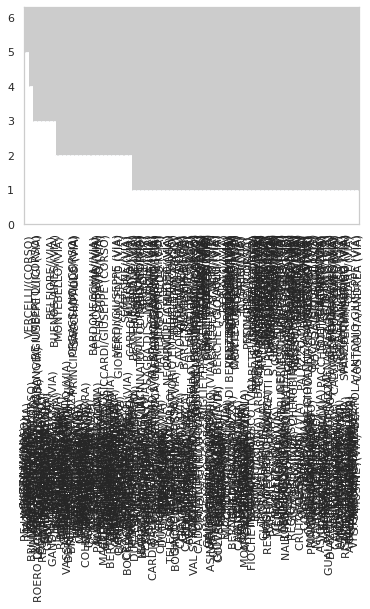

In [69]:
df_complaints['Localita'].value_counts().plot.bar()

<AxesSubplot:xlabel='Localita'>

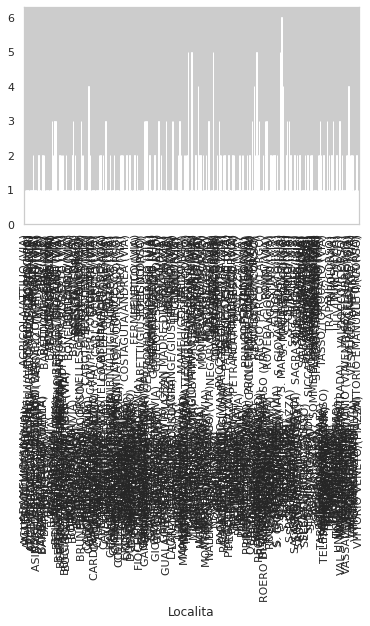

In [67]:
df_complaints.groupby('Localita').size().plot.bar()

In [81]:
gdf_zones = gpd.read_file(base+"/circoscrizioni.csv", sep=';')
gdf_zones.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_zones.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_zones

,WKT_GEOM,NCIRCO,DENOM,COORD_X,COORD_Y,geometry
0,"POLYGON ((1394020.6658 4989395.456,1394045.391...",1,Centro - Crocetta,"1395905,0625",4990759,None
1,"POLYGON ((1388021.1388 4988598.7439,1388196.68...",2,Santa Rita - Mirafiori,"1391345,375","4987441,5",None
2,"POLYGON ((1390109.823 4991844.4928,1390096.077...",3,San Paolo - Cenisia - Pozzo Strada - Cit Turin...,"1392548,5625","4991051,5",None
3,"POLYGON ((1390819.53 4995807.741,1390870.1669 ...",5,Borgo Vittoria - Madonna di Campagna - Lucento...,"1394087,75",4995618,None
4,"MULTIPOLYGON (((1400961.327 4997011.56,1400973...",6,Barriera di Milano - Regio Parco - Barca - Ber...,"1401325,375",4997202,None
5,"POLYGON ((1395455.966 4992801.3908,1395470.277...",7,"Aurora, Vanchiglia - Sassi - Madonna del Pilone","1399468,375","4991261,75",None
6,"POLYGON ((1392566.3958 4986473.023,1392495.074...",8,San Salvario - Cavoretto - Borgo Po - Nizza Mi...,"1396768,9375",4988491,None
7,"POLYGON ((1390275.648 4992144.6129,1390269.316...",4,San Donato - Campidoglio - Parella,"1392344,1875","4993558,5",None


In [82]:
gdf_zones = gpd.read_file(base+"/circoscrizioni_geo.zip")
gdf_zones.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_zones.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_zones

,NCIRCO,DENOM,geometry
0,1,Centro - Crocetta,"POLYGON ((7.65385 45.04991, 7.65489 45.05139, ..."
1,2,Santa Rita - Mirafiori,"POLYGON ((7.57787 45.04181, 7.58035 45.04427, ..."
2,3,San Paolo - Cenisia - Pozzo Strada - Cit Turin...,"POLYGON ((7.60367 45.07135, 7.60431 45.07222, ..."
3,5,Borgo Vittoria - Madonna di Campagna - Lucento...,"POLYGON ((7.61182 45.10712, 7.61264 45.10741, ..."
4,6,Barriera di Milano - Regio Parco - Barca - Ber...,"MULTIPOLYGON (((7.74046 45.11945, 7.74152 45.1..."
5,7,"Aurora, Vanchiglia - Sassi - Madonna del Pilone","POLYGON ((7.67136 45.08077, 7.67206 45.08175, ..."
6,8,San Salvario - Cavoretto - Borgo Po - Nizza Mi...,"POLYGON ((7.63602 45.02339, 7.63622 45.02355, ..."
7,4,San Donato - Campidoglio - Parella,"POLYGON ((7.60571 45.07408, 7.60575 45.07413, ..."


### Businesses and Noise Levels Analysis

Read file containing the businesses location and type and convert the coordinate system

In [51]:
gdf_businesses = gpd.read_file(base+"/businesses.csv", sep=';')
gdf_businesses.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_businesses.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system

gdf_businesses.head(10)

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type,geometry
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68288 45.05840)
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio,POINT (7.68288 45.05840)
2,POINT (1396303.762 4990325.001),VIA CLAUDIO LUIGI BERTHOLLET 25/F,2017,9,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68265 45.05861)
3,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2013,10,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68426 45.06057)
4,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2009,2,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68426 45.06057)
5,POINT (1396346.317 4990465.903),VIA PRINCIPE TOMMASO 3/G,2012,11,ALTRO,Somministrazione,Nessuna,POINT (7.68316 45.05988)
6,POINT (1396323.163 4990446.922),VIA PRINCIPE TOMMASO 6/E,2016,4,.,Somministrazione,Nessuna,POINT (7.68287 45.05971)
7,POINT (1396326.293 4990453.035),VIA PRINCIPE TOMMASO 6,1998,5,ALTRO,DIA di somministrazione,Nessuna,POINT (7.68290 45.05977)
8,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Gastronomia,POINT (7.67887 45.05985)
9,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2017,4,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)


In [58]:
d = dict.fromkeys(gdf_businesses.Description.unique())
d

{'PICCOLE STRUTTURE': None,
 'DIA di somministrazione': None,
 'Somministrazione': None,
 'Acconciatori/estetisti': None,
 'MEDIE STRUTTURE': None,
 'FORME SPECIALI DI VENDITA': None,
 'Attivita didattiche': None,
 'COSE ANTICHE E USATE': None}

In [ ]:
d['PICCOLE STRUTTURE'] = 'SMALL STRUCTURES'
d['DIA di somministrazione'] = 'DIA of administration'
d['Somministrazione'] = 'Administration'
d['Acconciatori/estetisti'] = 'Hairdressers / beauticians'
d['MEDIE STRUTTURE'] = 'MEDIUM STRUCTURES'
d['FORME SPECIALI DI VENDITA'] = 'SPECIAL FORMS OF SALE'
d['Attivita didattiche'] = 'Educational activities'
d['COSE ANTICHE E USATE'] = 'ANCIENT AND USED THINGS'

In [60]:
d = dict.fromkeys(gdf_businesses.TYPE.unique())
d

{'EXTRALIMENTARI': None,
 'ALIMENTARI': None,
 'ALTRO': None,
 '.': None,
 'MISTA': None}

In [ ]:
d['EXTRALIMENTARI'] = 'EXTRALIMENTARIES'
d['ALIMENTARI'] = 'FOOD'
d['ALTRO'] = 'OTHER'
d['.'] = '.'
d['MISTA'] = 'MIXED'

In [55]:
m=folium.Map(location=[45.05801, 7.68204], zoom_start=16)
def add_marker(map, station_name, lat, long):
    #print(lat)
    folium.Marker(location=[float(lat), float(long)], popup=station_name).add_to(map) 
    
gdf_businesses.apply(lambda l: add_marker(m, l['Description'],l.geometry.y, l.geometry.x),axis=1)

m

In [77]:
gpd_census = gpd.read_file(base+"/census_data/sezioni_censimento_geo_CAP.shp")
gpd_census

,SEZCENS,NCIRCO,DENCIM,LOCALITA,DISTRASS,PARROCCH,TIPOSEZ,ASL,ZONASTAT,NRESID,NFAMIGL,NMASCHI,NFEMM,NSTRAN,AN_0_14,AN_15_64,OLT_65_A,SUPERF,geometry
0,326.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,181.0,94.0,95.0,86.0,42.0,23.0,121.0,37.0,5593.24,"POLYGON ((1396082.920 4990558.645, 1396116.595..."
1,328.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,252.0,144.0,123.0,129.0,110.0,29.0,167.0,56.0,8403.30,"POLYGON ((1396230.062 4990481.191, 1396261.287..."
2,336.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,229.0,126.0,112.0,117.0,26.0,26.0,149.0,54.0,9976.84,"POLYGON ((1396319.969 4990427.448, 1396404.856..."
3,338.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,294.0,160.0,141.0,153.0,27.0,45.0,192.0,57.0,15116.92,"POLYGON ((1396509.732 4990327.177, 1396638.065..."
4,343.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,253.0,150.0,121.0,132.0,72.0,29.0,168.0,56.0,6922.80,"POLYGON ((1396272.570 4990334.580, 1396356.838..."
5,346.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,172.0,86.0,90.0,82.0,21.0,18.0,123.0,31.0,4052.06,"POLYGON ((1396110.590 4990337.667, 1396159.829..."
6,356.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,339.0,196.0,163.0,176.0,70.0,31.0,229.0,79.0,9174.29,"POLYGON ((1396289.940 4990160.821, 1396390.936..."
7,322.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,113.0,65.0,55.0,58.0,15.0,15.0,77.0,21.0,9446.12,"POLYGON ((1396389.050 4990563.934, 1396399.090..."
8,323.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,84.0,50.0,43.0,41.0,8.0,10.0,53.0,21.0,11706.68,"POLYGON ((1396486.289 4990539.884, 1396593.428..."
9,324.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,177.0,107.0,82.0,95.0,15.0,13.0,91.0,73.0,14107.72,"POLYGON ((1396593.428 4990483.221, 1396714.465..."


<AxesSubplot:>

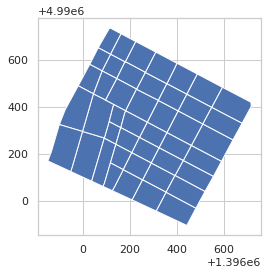

In [73]:
gpd_census.plot()

In [79]:

gpd_census = gpd.read_file(base+"/census_data/Torino_ACE81_3003.shp")
gpd_census

,COD_REG,COD_ISTAT,PRO_COM,SEZ2011,SEZ,COD_STAGNO,COD_FIUME,COD_LAGO,COD_LAGUNA,COD_VAL_P,...,COD_MONT_D,LOC2011,COD_LOC,TIPO_LOC,COM_ASC,COD_ASC,ACE,Shape_Leng,Shape_Area,geometry
0,1.0,1001272.0,1272.0,12720003790,3790.0,0.0,20019.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,601.187894,17122.466063,"POLYGON ((1397684.098 4990958.745, 1397676.338..."
1,1.0,1001272.0,1272.0,12720000331,331.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,451.345452,11664.272996,"POLYGON ((1396544.848 4990399.869, 1396674.057..."
2,1.0,1001272.0,1272.0,12720003788,3788.0,0.0,20019.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,1192.624459,27377.568756,"POLYGON ((1397381.695 4990677.529, 1397368.147..."
3,1.0,1001272.0,1272.0,12720002472,2472.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,2057.740794,43228.550156,"POLYGON ((1396824.866 4989610.669, 1396722.418..."
4,1.0,1001272.0,1272.0,12720000321,321.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,400.517124,10047.172479,"POLYGON ((1396298.448 4990620.419, 1396306.367..."
5,1.0,1001272.0,1272.0,12720000350,350.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,436.297481,10602.001633,"POLYGON ((1396423.431 4990173.513, 1396551.979..."
6,1.0,1001272.0,1272.0,12720000342,342.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,340.698338,7098.189539,"POLYGON ((1396158.959 4990319.998, 1396173.950..."
7,1.0,1001272.0,1272.0,12720000324,324.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,479.418676,14107.568787,"POLYGON ((1396590.755 4990485.467, 1396711.794..."
8,1.0,1001272.0,1272.0,12720000888,888.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,356.414916,8250.132066,"POLYGON ((1396186.680 4989126.652, 1396223.415..."
9,1.0,1001272.0,1272.0,12720003230,3230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,127210001.0,10001.0,1.0,1272008.0,8,81,310.518677,5262.393256,"POLYGON ((1396270.282 4988899.536, 1396299.801..."


<AxesSubplot:>

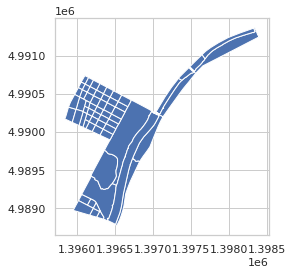

In [80]:
gpd_census.plot()